In [1]:
import os
import tarfile
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import DataLoader, Subset, Dataset
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# data_dir = "~/work/data_augmentation/data/Images/"
data_dir = "./data/Images/"

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [16]:
BATCH_SIZE = 128
EPOCHS = 20
NUM_CLASSES = 120
IMAGE_SIZE = 224
SEED = 42

In [5]:
def augment(image, label):
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ColorJitter(brightness=0.2),
    ])
    return transform(image), label

In [6]:
def normalize_and_resize_img(image, label):
    transform = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std =[0.229, 0.224, 0.225])
    ])
    return transform(image), label

In [7]:
# ----------------------------
# 원-핫 인코딩 (MixUp/CutMix용 soft label 만들 때 필요)
# ----------------------------
def onehot(label, num_classes=NUM_CLASSES):
    # label: (B,) tensor(long) 또는 int
    if isinstance(label, int):
        label = torch.tensor(label, dtype=torch.long)
    return torch.nn.functional.one_hot(label, num_classes=num_classes).float()

In [8]:
def soft_cross_entropy_from_logits(logits, targets_soft):
    log_probs = torch.log_softmax(logits, dim=1)
    return -(targets_soft * log_probs).sum(dim=1).mean()


In [9]:
def apply_mixup(x, y_onehot, alpha=1.0):
    if alpha <= 0:
        return x, y_onehot

    lam = np.random.beta(alpha, alpha)
    idx = torch.randperm(x.size(0), device=x.device)
    x_mix = lam * x + (1 - lam) * x[idx]
    y_mix = lam * y_onehot + (1 - lam) * y_onehot[idx]
    return x_mix, y_mix

In [10]:
def rand_bbox(H, W, lam):
    cut_rat = np.sqrt(1.0 - lam)
    cut_h = int(H * cut_rat)
    cut_w = int(W * cut_rat)

    cy = np.random.randint(H)
    cx = np.random.randint(W)

    y1 = np.clip(cy - cut_h // 2, 0, H)
    y2 = np.clip(cy + cut_h // 2, 0, H)
    x1 = np.clip(cx - cut_w // 2, 0, W)
    x2 = np.clip(cx + cut_w // 2, 0, W)
    return y1, y2, x1, x2

In [11]:
def apply_cutmix(x, y_onehot, alpha=1.0):
    if alpha <= 0:
        return x, y_onehot

    lam = np.random.beta(alpha, alpha)
    idx = torch.randperm(x.size(0), device=x.device)

    B, C, H, W = x.size()
    y1, y2, x1, x2 = rand_bbox(H, W, lam)

    x_cut = x.clone()
    x_cut[:, :, y1:y2, x1:x2] = x[idx, :, y1:y2, x1:x2]

    area = (y2 - y1) * (x2 - x1)
    lam_adj = 1.0 - area / float(H * W)

    y_cut = lam_adj * y_onehot + (1.0 - lam_adj) * y_onehot[idx]
    return x_cut, y_cut


In [17]:
class TransformWrapper(Dataset):
    def __init__(self, base_subset, is_test=False, with_aug=False):
        self.base = base_subset
        self.is_test = is_test
        self.with_aug = with_aug

    def __len__(self):
        return len(self.base)

    def __getitem__(self, idx):
        img, lbl = self.base[idx]  # PIL, int
        if (not self.is_test) and self.with_aug:
            img, lbl = augment(img, lbl)
        img, lbl = normalize_and_resize_img(img, lbl)
        return img, lbl

def apply_normalize_on_dataset(dataset, is_test=False, batch_size=32, with_aug=False):
    wrapped = TransformWrapper(dataset, is_test=is_test, with_aug=with_aug)

    loader = DataLoader(
        wrapped,
        batch_size=batch_size,
        shuffle=not is_test,
        num_workers=4,      # 중요: 2 -> 0
        pin_memory=False    # 중요: True -> False
    )
    return loader

In [18]:
def make_split_indices(n, seed=SEED):
    idx = np.arange(n)
    rng = np.random.default_rng(seed)
    rng.shuffle(idx)
    train_size = int(0.8 * n)
    train_idx = idx[:train_size].tolist()
    val_idx = idx[train_size:].tolist()
    return train_idx, val_idx


In [19]:
def train_experiment(mode='none', mixup_alpha=1.0, cutmix_alpha=1.0):
    # base dataset (PIL + label)
    base_full = torchvision.datasets.ImageFolder(root=data_dir)  # transform=None => PIL 반환
    n = len(base_full)
    train_idx, val_idx = make_split_indices(n)

    train_ds = Subset(base_full, train_idx)
    val_ds   = Subset(base_full, val_idx)

    # mode에 따라 "기본 augmentation" 유무만 loader 단계에서 결정
    with_aug = (mode != 'none')  # basic/mixup/cutmix는 기본 증강 포함
    train_loader = apply_normalize_on_dataset(train_ds, is_test=False, batch_size=BATCH_SIZE, with_aug=with_aug)
    val_loader   = apply_normalize_on_dataset(val_ds, is_test=True,  batch_size=BATCH_SIZE, with_aug=False)

    # 모델
    model = models.resnet50(weights='IMAGENET1K_V1')
    model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)
    model = model.to(device)

    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    history = {'loss': [], 'acc': []}

    for epoch in range(EPOCHS):
        model.train()
        total_loss = 0.0

        for x, y in train_loader:
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True).long()

            y_onehot = onehot(y, NUM_CLASSES).to(device)

            # mode에 따라 배치 섞기
            if mode == 'mixup':
                x, y_onehot = apply_mixup(x, y_onehot, alpha=mixup_alpha)
            elif mode == 'cutmix':
                x, y_onehot = apply_cutmix(x, y_onehot, alpha=cutmix_alpha)
            # 'none'/'basic'는 섞기 없음

            optimizer.zero_grad(set_to_none=True)
            logits = model(x)
            loss = soft_cross_entropy_from_logits(logits, y_onehot)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        # validation (hard accuracy)
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for x, y in val_loader:
                x = x.to(device, non_blocking=True)
                y = y.to(device, non_blocking=True).long()
                logits = model(x)
                pred = logits.argmax(dim=1)
                correct += (pred == y).sum().item()
                total += y.size(0)

        acc = 100.0 * correct / total
        history['loss'].append(total_loss / len(train_loader))
        history['acc'].append(acc)
        print(f"[{mode}] Epoch {epoch+1}/{EPOCHS}: Loss {history['loss'][-1]:.4f}, Acc {acc:.2f}%")

    return history


In [20]:
modes = ['none', 'basic', 'mixup', 'cutmix']
results = {}

for m in modes:
    results[m] = train_experiment(m)

[none] Epoch 1/20: Loss 4.0711, Acc 57.58%
[none] Epoch 2/20: Loss 2.2625, Acc 76.34%
[none] Epoch 3/20: Loss 1.2968, Acc 81.17%
[none] Epoch 4/20: Loss 0.8977, Acc 82.53%
[none] Epoch 5/20: Loss 0.6908, Acc 83.09%
[none] Epoch 6/20: Loss 0.5560, Acc 83.77%
[none] Epoch 7/20: Loss 0.4580, Acc 84.04%
[none] Epoch 8/20: Loss 0.3821, Acc 84.01%
[none] Epoch 9/20: Loss 0.3241, Acc 84.74%
[none] Epoch 10/20: Loss 0.2786, Acc 84.72%
[none] Epoch 11/20: Loss 0.2375, Acc 84.45%
[none] Epoch 12/20: Loss 0.2019, Acc 84.40%
[none] Epoch 13/20: Loss 0.1753, Acc 84.33%
[none] Epoch 14/20: Loss 0.1500, Acc 84.50%
[none] Epoch 15/20: Loss 0.1324, Acc 84.57%
[none] Epoch 16/20: Loss 0.1152, Acc 84.33%
[none] Epoch 17/20: Loss 0.1015, Acc 84.18%
[none] Epoch 18/20: Loss 0.0886, Acc 84.26%
[none] Epoch 19/20: Loss 0.0775, Acc 84.28%
[none] Epoch 20/20: Loss 0.0687, Acc 84.18%
[basic] Epoch 1/20: Loss 4.0638, Acc 58.82%
[basic] Epoch 2/20: Loss 2.2742, Acc 76.58%
[basic] Epoch 3/20: Loss 1.3279, Acc 80.8

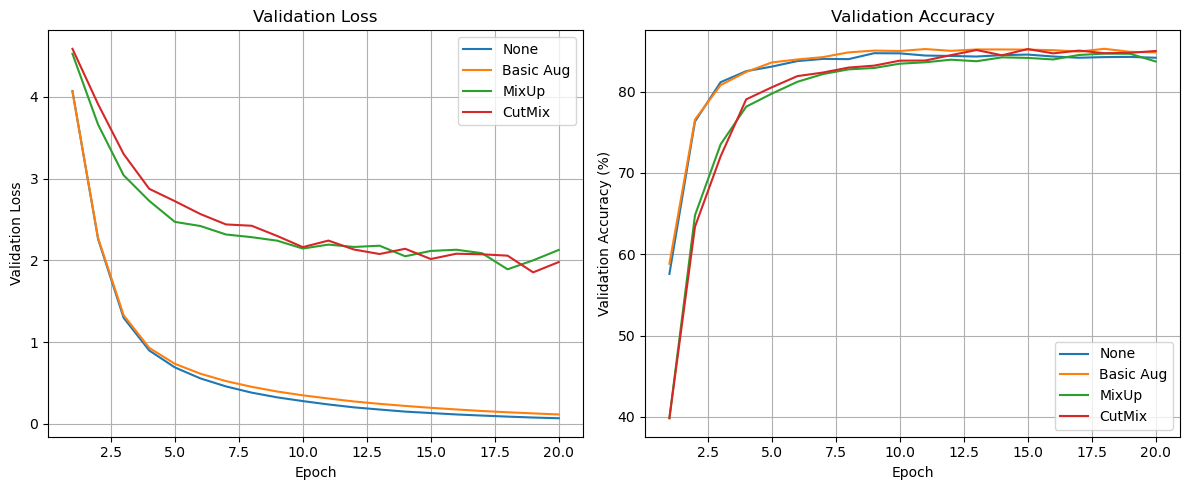

In [4]:
import matplotlib.pyplot as plt

# Epochs
epochs = list(range(1, 21))

# ===== Validation Loss =====
loss_none = [4.0711,2.2625,1.2968,0.8977,0.6908,0.5560,0.4580,0.3821,0.3241,0.2786,
             0.2375,0.2019,0.1753,0.1500,0.1324,0.1152,0.1015,0.0886,0.0775,0.0687]

loss_basic = [4.0638,2.2742,1.3279,0.9294,0.7349,0.6134,0.5230,0.4533,0.3956,0.3492,
              0.3103,0.2739,0.2448,0.2195,0.1964,0.1763,0.1574,0.1419,0.1282,0.1151]

loss_mixup = [4.5267,3.6622,3.0410,2.7276,2.4709,2.4201,2.3164,2.2840,2.2409,2.1448,
              2.1929,2.1642,2.1794,2.0501,2.1156,2.1300,2.0880,1.8907,2.0005,2.1276]

loss_cutmix = [4.5881,3.9111,3.3006,2.8753,2.7243,2.5665,2.4395,2.4236,2.2985,2.1620,
               2.2421,2.1326,2.0777,2.1420,2.0164,2.0813,2.0742,2.0578,1.8535,1.9795]

# ===== Validation Accuracy =====
acc_none = [57.58,76.34,81.17,82.53,83.09,83.77,84.04,84.01,84.74,84.72,
            84.45,84.40,84.33,84.50,84.57,84.33,84.18,84.26,84.28,84.18]

acc_basic = [58.82,76.58,80.81,82.43,83.60,83.97,84.26,84.84,85.06,85.01,
             85.25,85.03,85.20,85.20,85.18,85.11,84.94,85.28,84.91,84.84]

acc_mixup = [39.84,64.80,73.52,78.16,79.76,81.22,82.17,82.75,82.92,83.45,
             83.62,83.94,83.75,84.23,84.16,83.97,84.52,84.69,84.67,83.72]

acc_cutmix = [39.82,63.39,72.04,79.06,80.54,81.92,82.36,82.97,83.21,83.82,
              83.84,84.50,85.13,84.48,85.25,84.72,85.06,84.74,84.79,85.01]

# ===== Plot =====
plt.figure(figsize=(12, 5))

# Loss subplot
plt.subplot(1, 2, 1)
plt.plot(epochs, loss_none, label="None")
plt.plot(epochs, loss_basic, label="Basic Aug")
plt.plot(epochs, loss_mixup, label="MixUp")
plt.plot(epochs, loss_cutmix, label="CutMix")
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.title("Validation Loss")
plt.legend()
plt.grid(True)

# Accuracy subplot
plt.subplot(1, 2, 2)
plt.plot(epochs, acc_none, label="None")
plt.plot(epochs, acc_basic, label="Basic Aug")
plt.plot(epochs, acc_mixup, label="MixUp")
plt.plot(epochs, acc_cutmix, label="CutMix")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy (%)")
plt.title("Validation Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [5]:
import pandas as pd

modes = ["none", "basic", "mixup", "cutmix"]

losses = {
    "none": loss_none,
    "basic": loss_basic,
    "mixup": loss_mixup,
    "cutmix": loss_cutmix,
}

accs = {
    "none": acc_none,
    "basic": acc_basic,
    "mixup": acc_mixup,
    "cutmix": acc_cutmix,
}

final_df = pd.DataFrame({
    "Method": modes,
    "Max Acc": [max(accs[m]) for m in modes],
    "Final Val Loss": [losses[m][-1] for m in modes],
    "Max Acc Epoch(1-based)": [accs[m].index(max(accs[m])) + 1 for m in modes],
})

print(final_df)

   Method  Max Acc  Final Val Loss  Max Acc Epoch(1-based)
0    none    84.74          0.0687                       9
1   basic    85.28          0.1151                      18
2   mixup    84.69          2.1276                      18
3  cutmix    85.25          1.9795                      15


## 실험 결과 회고 (Validation 기준)

### 1. 실험 개요
본 실험에서는 Stanford Dogs 데이터셋을 활용하여 데이터 증강 기법에 따른 모델 성능 차이를 비교하였다.  
비교 대상은 다음 네 가지 학습 전략이다.

- **None**: 데이터 증강 없이 학습
- **Basic Augmentation**: 기본적인 이미지 증강(Random Flip 등) 적용
- **MixUp**: 두 이미지를 선형 결합하여 학습
- **CutMix**: 이미지의 일부 영역을 다른 이미지로 교체하여 학습

평가 지표로는 **Validation Accuracy**와 **Validation Loss**를 사용하였다.

---

### 2. Validation Loss 분석
Validation Loss 변화에서 다음과 같은 특징을 확인할 수 있었다.

- **None / Basic Augmentation**
  - 학습 초반부터 loss가 빠르게 감소
  - epoch가 증가함에 따라 안정적으로 수렴
  - 최종 Validation Loss가 매우 낮은 수준으로 유지됨

- **MixUp / CutMix**
  - 전반적으로 loss 값이 높게 유지됨
  - soft label 기반 학습으로 인해 loss가 직접적으로 낮아지지 않음
  - 이는 학습 불안정이 아닌 **loss 정의 차이에 따른 자연스러운 현상**임

---

### 3. Validation Accuracy 분석
Validation Accuracy 측면에서는 보다 명확한 성능 차이가 나타났다.

- **None**
  - 비교적 빠르게 높은 정확도에 도달
  - 최대 정확도: **84.74% (Epoch 9)**

- **Basic Augmentation**
  - None 대비 전반적으로 높은 정확도 유지
  - 최대 정확도: **85.28% (Epoch 18)**
  - 단순한 증강만으로도 일반화 성능이 향상됨을 확인

- **MixUp**
  - 학습 초반 정확도가 낮게 시작
  - 점진적으로 성능이 개선되며 후반부에 None과 유사한 수준 도달
  - 최대 정확도: **84.69% (Epoch 18)**

- **CutMix**
  - 학습 초반 수렴 속도는 느리지만
  - 후반부에서 가장 높은 수준의 정확도 달성
  - 최대 정확도: **85.25% (Epoch 15)**

---

### 4. 성능 지표 요약

| Method  | Max Accuracy (%) | Max Acc Epoch | Final Val Loss |
|--------|------------------|---------------|----------------|
| None   | 84.74            | 9             | 0.0687         |
| Basic  | 85.28            | 18            | 0.1151         |
| MixUp  | 84.69            | 18            | 2.1276         |
| CutMix | 85.25            | 15            | 1.9795         |

---

### 5. 종합 회고
- **Basic Augmentation**은 구현이 단순하면서도 가장 안정적인 성능 향상을 제공하였다.
- **MixUp과 CutMix**는 강한 정규화 효과로 인해 학습 초반 수렴이 느리지만, 충분한 epoch가 주어질 경우 일반화 성능 향상에 기여함을 확인하였다.
- 특히 **CutMix는 가장 높은 validation accuracy를 기록**하며, 구조적 데이터 증강의 효과를 명확히 보여주었다.

---

